Marissa Graham, Math 404, 2/8/2016

In [8]:
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from scipy.stats import norm as normal
from __future__ import division
%matplotlib inline

def get_flips(n,theta=None):
    """
    Generate data for the three-coin problem. 
    Note: heads is 1 and tails is 0
    
    Inputs
    ------
    n: number of flips of coin 0 to generate
    theta: probability vector l, p1, p2.
         If theta is None, randomly generate l, p1, p2.
    
    Outputs
    -------
    out: 3xn NumPy array with the desired data.
    """
    
    if not theta:
        theta = np.random.rand(3)
       
    out = np.zeros((3,n))
    coin_zero = np.random.binomial(1,theta[0],n)
    
    for i in xrange(n):
        # We could do this in one line but this is more clear
        if coin_zero[i] == 1:
            # Toss coin 1 three times
            out[:,i] = np.random.binomial(1,theta[1],3)
        else:
            # Toss coin 2 three times
            out[:,i] = np.random.binomial(1,theta[2],3)
            
    return out

def getP(X,theta):
    """Calculate P(Y=h,X) using current parameters in theta."""
    
    # Get number of heads in each draw
    h = np.sum(X,axis=0)
    t = 3 - h
    l, p1, p2 = theta[0], theta[1], theta[2]
    
    P_heads = l * p1**h * (1-p1)**t
    P_tails = (1-l) * p2**h * (1-p2)**t
    
    return P_heads / (P_heads + P_tails)
    

def EM(X,theta0):
    """
    Calculate the maximum likelihood estimate for data given
    by the three coin problem. 
    
    Inputs
    ------
    flip_data: a 3xn NumPy array containing the triple flips
        of coin 1 and coin 2, as given by get_flips()
    theta0: initial guess for theta.
        
    Outputs
    -------
    out: full (n+1)x(n+3) table containing guesses for theta 
        at all stages as well as posterior probabilities at 
        each stage. Final theta results found in out[-1,:3]
    """
    n = X.shape[1]
    h = np.sum(X,axis=0)
    out = np.zeros((n+1,n+3))
    out[0,:3] = theta0
    
    # Fill in hidden variables P(Y=h,X) using initial guess
    out[0,3:] = getP(X,theta0)
    
    for i in xrange(1,n+1):
        # Re-estimate parameters using hidden variables from i-1
        prev = out[i-1,3:]
        l = np.sum(prev)/n
        p1 = np.sum(h*prev) / (3*np.sum(prev))
        p2 = np.sum(h*(1-prev)) / (3*np.sum(1-prev))
        out[i,:3] = np.array([l,p1,p2])
        
        # Fill in hidden variables
        out[i,3:] = getP(X,np.array([l,p1,p2]))
        
    return out

We run our first test on Y = {(HHH),(TTT),(HHH),(TTT)}. Note that the
first three columns of the output array give us our estimate for $\theta$
at each step, while the rest of the columns give us the posterior
probabilities (e.g. how sure we are of which coin generated each flip).

In [9]:
X = np.array([[1,0,1,0],[1,0,1,0],[1,0,1,0]],dtype=np.float)
results = EM(X,np.array([0.3,0.3,0.6]))
np.set_printoptions(precision=4,suppress=True)
print results

[[ 0.3     0.3     0.6     0.0508  0.6967  0.0508  0.6967]
 [ 0.3738  0.068   0.7578  0.0004  0.9714  0.0004  0.9714]
 [ 0.4859  0.0004  0.9722  0.      1.      0.      1.    ]
 [ 0.5     0.      1.      0.      1.      0.      1.    ]
 [ 0.5     0.      1.      0.      1.      0.      1.    ]]


As we can see, this corresponds to a coin which always shows heads and
a coin which always shows tails, which appear with equal probability.
As a result, we are certain that the tail-biased coin 1 generated the 
second and fourth draws, while the head-biased coin 2 generated the others. 
We now run the test on Y = {(HHT),(TTT),(HHH),(TTT)}.

In [10]:
X = np.array([[1,0,1,0],[1,0,1,0],[0,0,1,0]],dtype=np.float)
results = EM(X,np.array([0.3,0.3,0.6]))
np.set_printoptions(precision=4,suppress=True)
print results

[[ 0.3     0.3     0.6     0.1579  0.6967  0.0508  0.6967]
 [ 0.4005  0.0974  0.63    0.0375  0.9065  0.0025  0.9065]
 [ 0.4632  0.0148  0.7635  0.0014  0.9842  0.      0.9842]
 [ 0.4924  0.0005  0.8205  0.      0.9941  0.      0.9941]
 [ 0.497   0.      0.8284  0.      0.9949  0.      0.9949]]


We see that we have a tails-only coin and a coin which is heavily 
biased towards heads. We are no longer completely sure that the 
second and fourth draws are generated by the tails-only coin (since
it is possible, though unlikely, for the heads-biased coin to generate
a tails-only draw), but it is highly unlikely.

We now investigate the Gaussian mixture model.

In [11]:
def gmm_data_generator(lambdas,mus,sigmas,iters=500):
    
    for i in xrange(iters):
        
        index = np.random.multinomial(1,lambdas).argmax()
        yield np.random.normal(mus[index],np.sqrt(sigmas[index]))
        
class GMM(object):
    
    def __init__(self, num_gaussians=3):
        
        self.n = num_gaussians
        
    def add_observation(self,x):
        
        if not hasattr(self,"data"):
            self.data = [x]
        
        else:
            self.data.append(x)
            
    def _wij(self):
        
        wij = np.array([self.lambdas[j]*normal.pdf(self.data, self.mus[j], np.sqrt(self.sigmas[j])) for j in xrange(self.n)])
        wij = wij / np.sum(wij,axis=0)
        return wij
    
    def estimate(self,lambdas,mus,sigmas,iters=100):
        
        self.lambdas = lambdas
        self.mus = mus
        self.sigmas = sigmas
        length = len(self.data)
        
        for i in xrange(iters):
            
            wij = self._wij()
            for j in xrange(self.n):
                wi_j = wij[j]
                sum_wij = np.sum(wi_j)
                self.lambdas[j] = sum_wij / len(wi_j)
                self.mus[j] = np.sum(wi_j*self.data) / sum_wij
                self.sigmas[j] = np.sum(wi_j*np.abs(self.data-self.mus[j])**2) / sum_wij
            
    @staticmethod
    def plot_mixture(lambdas,mus,sigmas,title="Estimate"):
        
        n = len(lambdas)
        mean = np.mean(mus)
        std = np.std(mus)
        domain = np.linspace(mean-4*std,mean+4*std,200)
        data = np.zeros_like(domain)
        
        for i in xrange(n):
            
            gauss_i = lambdas[i]*normal.pdf(domain,mus[i],np.sqrt(sigmas[i]))
            data = data + gauss_i
            plt.plot(domain,gauss_i,'--',label="$\lambda = {},\ \mu = {},\ \sigma^2 = {}$".format(lambdas[i], mus[i], sigmas[i]))
        
        plt.plot(domain,data,'k',label="Mixture")
        plt.xlim(domain[0],domain[-1])
        plt.title(title)
        
        plt.show()
        
    def display(self):
        
        for item in ["lambdas","mus","sigmas"]:
            
            self.plot_mixture(self.lambdas,self.mus,self.sigmas)
 
def test_gmm(_lambdas,_mus,_sigmas,lambdas,mus,sigmas,obs=500,iters=100,n=3):
    
    gmm = GMM(n)
    for trial in gmm_data_generator(_lambdas,_mus,_sigmas,obs):
        
        gmm.add_observation(trial)   
    gmm.estimate(lambdas,mus,sigmas,iters)
    
    plt.subplot(121)
    gmm.display()
    plt.subplot(122)
    GMM.plot_mixture(_lambdas,_mus,_sigmas,"Actual")
    plt.show()
    
    gmm.display()
    GMM.plot_mixture(_lambdas,_mus,_sigmas,"Together")
    plt.show() 

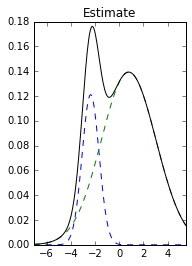

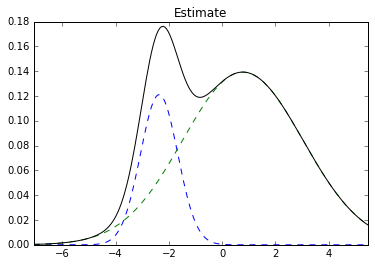

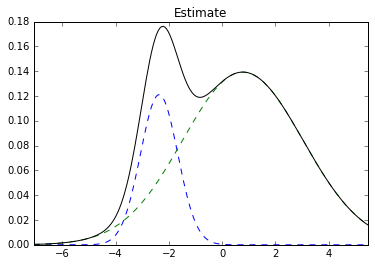

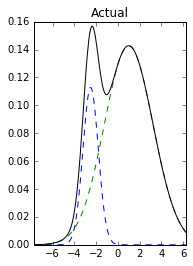

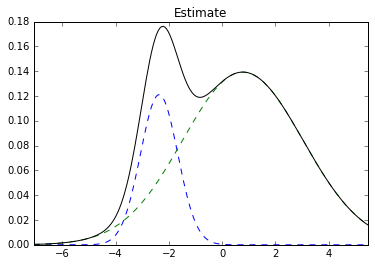

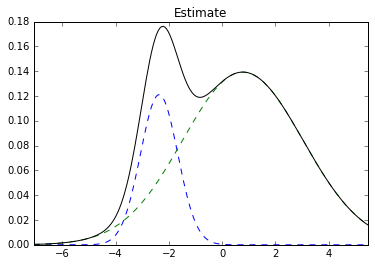

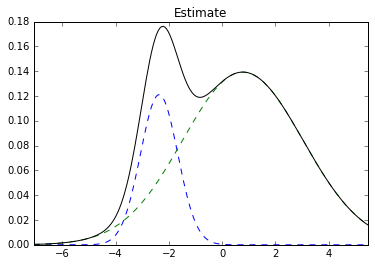

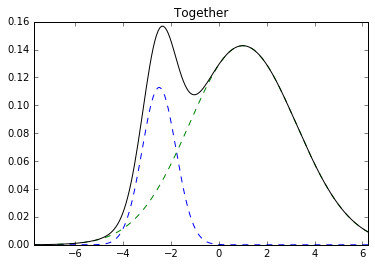

In [12]:
test_gmm([.2,.8], [-2.5, 1.], [.5, 5.], [.4, .6], [-4., 1.5], [.3, 1.], n=2)